# Project Outline

The goal of this project is to implement an agent based markov model to simulate the transmission of an infectious disease. We also aim to investigate other comparment models such as the SIS model (elusive recovery) and the SIRV model (vaccine availability) - as well as introduce other variables like "Age". We update fatality rates based on new data, and the impact of symptomatic infection rates. 

## Aggregate Model in R

In [2]:
#!pip install rpy2
#!pip install bokeh
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
%load_ext rpy2.ipython

import seaborn as sns
import matplotlib.pyplot as plt

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [3]:
%%R
#From Miller Code
library(markovchain)
stateNames = c("susceptible", "infected", "immune", "dead")
contagionRate = 0.1
fatalityRate = 0.0006 #using symptomatic rate of 0.15
transitionMatrix = matrix(c((1-contagionRate),contagionRate, 0, 0,
                            0, 0, (1-fatalityRate),fatalityRate,
                            0, 0, 1, 0,
                            0, 0, 0, 1),
                          byrow = TRUE, nrow = 4,
                          dimnames = list(stateNames, stateNames))
epidemic = new("markovchain", transitionMatrix = transitionMatrix)
initialState = c(0.99,0.01,0.00,0.00)
millerdata <- data.frame(matrix(ncol = 5, nrow = 0))
x <- c("Step","Susceptible", "Infected", "Immune", "Dead")
colnames(millerdata) <- x
for (i in 0:100){
state = initialState * (epidemic ^ i)
millerdata[nrow(millerdata)+1,]=c(i,state)
}

Package:  markovchain
Version:  0.9.3
Date:     2023-05-18 10:50:02 UTC
BugReport: https://github.com/spedygiorgio/markovchain/issues



In [4]:
#moving to python

millerdata_fromr=robjects.globalenv['millerdata']
with (robjects.default_converter + pandas2ri.converter).context():
    millerdata = robjects.conversion.get_conversion().rpy2py(millerdata_fromr)

millerdata

,Step,Susceptible,Infected,Immune,Dead
1,0.0,0.990000,0.010000,0.000000,0.000000
2,1.0,0.891000,0.099000,0.009994,0.000006
3,2.0,0.801900,0.089100,0.108935,0.000065
4,3.0,0.721710,0.080190,0.197981,0.000119
5,4.0,0.649539,0.072171,0.278123,0.000167
...,...,...,...,...,...
97,96.0,0.000040,0.000004,0.999355,0.000600
98,97.0,0.000036,0.000004,0.999360,0.000600
99,98.0,0.000032,0.000004,0.999364,0.000600
100,99.0,0.000029,0.000003,0.999368,0.000600


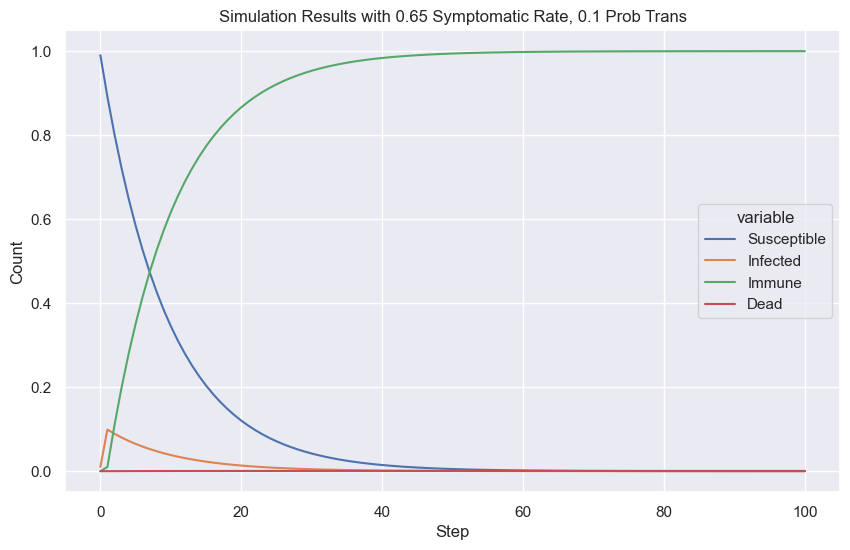

In [5]:
#Plotting

millerdata= millerdata.melt('Step')
# Style
sns.set(style='darkgrid')
plt.figure(figsize=(10, 6))

# Line plot
sns.lineplot(data=millerdata, x= 'Step', y='value', hue='variable')

# Labels
plt.xlabel('Step')
plt.ylabel('Count')
plt.title('Simulation Results with 0.65 Symptomatic Rate, 0.1 Prob Trans')

# Show
plt.show()

## Agent-Based Model in Python

In [1]:
# Mesa Package
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector

# Random stuff we need
import random
import numpy as np
import enum

# Multi grid..? instead of Grid
from mesa.space import MultiGrid

# Pandas
import pandas as pd

### 1) Define the Model

In [2]:
## --------------------------------------------------------------- ##
## -------------------------- MODEL ------------------------------ ##
## --------------------------------------------------------------- ##

# Create the disease model class
class DiseaseModel(Model):
    
    # Attributes of the model
    def __init__(self, num_agents, num_steps,
             symptomatic_rate = .15, recovery_type = "elusive",
             vaccine_available = False, prob_trans = .15, death_rate=0.002*0.15):

        # Ensures the class is properly initialized
        super().__init__()
        
## --------------------------------------------------------------- ##
## ---------- ASSIGNING DEFAULT ATTRIBUTES TO THE AGENTS --------- ##
## --------------------------------------------------------------- ##

        # Assigning each of the attributes to the simulation
        self.num_agents = num_agents
        self.num_steps = num_steps
        self.symptomatic_rate = symptomatic_rate
        self.death_rate = death_rate
        self.recovery_type = recovery_type
        self.vaccine_available = vaccine_available
        self.prob_trans = prob_trans
        
        # Create the grid and scheduler
        self.grid = MultiGrid(10, 10, torus=True)
        self.schedule = RandomActivation(self)
        
        # Is the model currently running // keep track of dead 
        self.running = True
        self.dead_agents = []
        
## --------------------------------------------------------------- ##
## -------- LOOP TO CREATE AGENTS AND INITIALIZE PROPERTIES ------ ##
## --------------------------------------------------------------- ##

        # Loop through num agents
        for i in range(self.num_agents):
            
            # Create the agent object uinsg an agent class below
            agent = ThisAgent(i, self)
            
            # Add the agent to the schedule
            self.schedule.add(agent)
            
            # Randomly choose starting position and add
            x = random.randrange(self.grid.width)
            y = random.randrange(self.grid.height)
            self.grid.place_agent(agent, (x, y))
            
            # A portion will initially be randomly infeced
            infected = np.random.choice([0, 1], p=[0.99, 0.01])
            
            # If infected, get the recovery time
            if infected == 1:
                agent.state = State.INFECTED
                agent.recovery_time = self.get_recovery_time()
                
            # Distribution of age for the agent
            age = np.random.choice(["Child", "Adult", "Elder"], p=[0.2, 0.6, 0.2])
            agent.age = age

            # Fatality rate depending on age (function below)
            fatality_rate = self.get_fatality_rate(age)
            agent.fatality_rate = fatality_rate          
        
            # Initialize the data collector
            self.datacollector = DataCollector(
                
                # Collecting the state of the agent data
                agent_reporters={"State": lambda agent: agent.state,
                                 "Age": lambda agent: agent.age},
                
                # Collecting aggregate model data
                model_reporters={
                    "Step": lambda model: self.schedule.time,
                    "Susceptible": lambda model: sum(agent.state == State.SUSCEPTIBLE for agent in model.schedule.agents),
                    "Infected": lambda model: sum(agent.state == State.INFECTED for agent in model.schedule.agents),
                    "Immune": lambda model: sum(agent.state == State.IMMUNE for agent in model.schedule.agents),
                    "Dead": lambda model: len(self.dead_agents),
                }
            )

## --------------------------------------------------------------- ##
## ---- SEQUENCE OF ACTIONS TO OCCUR EACH STEP OF SIMULATION ----- ##
## --------------------------------------------------------------- ##
    
    # Step
    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()


## --------------------------------------------------------------- ##
## ------- RUN SIMULATION FOR A SPECIFIED NUMBER OF STEPS -------- ##
## --------------------------------------------------------------- ##
    
    # Run function
    def run(self):
        
        # List for the data
        data = []

        # Loop through one step at a time
        for _ in range(self.num_steps):
            self.step()

            # Collect data
            step_data = self.datacollector.get_model_vars_dataframe()
            data.append(step_data)

        # Concatenate the collected data into a single table or dataframe
        table = pd.concat(data)

        # Return our table
        return table
    
    
            
## --------------------------------------------------------------- ##
## --------- GET THE RECOVERY TIME FOR A SPECIFIC AGENT ---------- ##
## --------------------------------------------------------------- ##            

    # Pass simulation argument
    def get_recovery_time(self):

            # Mean of 10 and standard deviation of 3
            return int(random.normalvariate(10, 3))

    ## --------------------------------------------------------------- ##
    ## --------- GET THE FATALITY RATE FOR A SPECIFIC AGENT ---------- ##
    ## --------------------------------------------------------------- ##    

    # Pass simulation and age
    def get_fatality_rate(self, age):

        # 1 percent fatality for children
        if age == "Child":
            return 0.0005*self.symptomatic_rate

        # 5 percent for adults
        elif age == "Adult":
            return 0.002*self.symptomatic_rate

        # 20 percent for elders
        elif age == "Elder":
            return 0.013*self.symptomatic_rate

### 2) Create State and Agent Classes

In [3]:
# Create the state class
class State(enum.IntEnum):
    
    # Four categories
    SUSCEPTIBLE = 0
    INFECTED = 1
    DEAD = 2
    IMMUNE = 3

In [4]:
## --------------------------------------------------------------- ##
## ---------- INITIALIZE CLASS AND CREATE DEFAULT AGENT ---------- ##
## --------------------------------------------------------------- ##    

# Create the specific agent class
class ThisAgent(Agent):

    # Self, unique id, and a reference to the model
    def __init__(self, unique_id, model):
        
        # Make sure it initializes correctly
        super().__init__(unique_id, model)
        
        # Default to susceptible and infection time 0
        self.state = State.SUSCEPTIBLE
        self.infection_time = 0
        
        # Recovery time
        self.recovery_time = 0
        
        # Add the immunity status of the self
        self.immunity_status = False

## --------------------------------------------------------------- ##
## ------------------------ MOVE THE AGENT ----------------------- ##
## --------------------------------------------------------------- ##
    
    # Define the functions
    def move(self):

        # Get a list of possible steps
        possible_steps = self.model.grid.get_neighborhood(
            self.pos,
            moore=True,
            include_center=False
        )
        
        # Randomly select a new position
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

## --------------------------------------------------------------- ##
## ------------------- UPDATE INFECTION STATUS ------------------- ##
## --------------------------------------------------------------- ##
   
    # Define the function
    def status(self):

        # If they are infected check the death rate
        if self.state == State.INFECTED:
            drate = self.fatality_rate
            alive = np.random.choice([0, 1], p=[drate, 1 - drate])

            # If they are dead
            if alive == 0:
                self.state = State.DEAD
                self.model.dead_agents.append(self)

                
            # Time 
            t = self.model.schedule.time - self.infection_time
            
            if self.model.recovery_type == 'elusive':
                #SIS model
                if t >= self.recovery_time:
                    self.state = State.SUSCEPTIBLE

            else:
                #SIR model
                if t >= self.recovery_time:
                    self.state = State.IMMUNE

                    # Change their immunity status to true
                    self.immunity_status = True
             
        elif self.state == State.SUSCEPTIBLE:
            vrate = 0.99
            vaxed = np.random.choice([0,1], p =[vrate, 1-vrate])
            
            if self.model.recovery_type=="vax":
                if vaxed == 1:
                    self.state = State.IMMUNE
                    self.immunity_status = True
                    
        elif self.state == State.IMMUNE:
            resus = 0.99
            resused = np.random.choice([0,1], p =[resus, 1-resus])
            if resused == 1:
                self.state = State.SUSCEPTIBLE
                self.immunity_status = False
            
## --------------------------------------------------------------- ##
## ------------------ GET NEIGHBORS AND INFECT ------------------- ##
## --------------------------------------------------------------- ##
    
    # Define the contact function
    def contact(self):

        # Identify people that are close
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        
        # If the agent is in the IMMUNE state, they cannot infect others
        if self.state is State.IMMUNE:
            return
        
        # Infect or don't infect?
        if len(cellmates) > 1:
            for other in cellmates:
                
                # Check probability of transmission
                if self.random.random() > self.model.prob_trans:
                    continue
                    
                # Check if they are susceptible // can be infected
                if (
                    self.state is State.INFECTED
                    and other.state is State.SUSCEPTIBLE
                ):
                    
                    # Infect the susceptible agent
                    other.state = State.INFECTED
                    other.infection_time = self.model.schedule.time
                    other.recovery_time = self.model.get_recovery_time()

## --------------------------------------------------------------- ##
## ------------------ ACTUALLY PERFORM THE STEPS ----------------- ##
## --------------------------------------------------------------- ##
    def step(self):
        self.status()
        self.move()
        self.contact()

In [5]:
# Create an instance of the DiseaseModel
model = DiseaseModel(num_agents=1000, num_steps=100, prob_trans=0.3, symptomatic_rate=0.65, recovery_type='elusive')

# Run the simulation and collect data
table = model.run()

# Print or inspect the collected data
print(table[["Step", "Susceptible", "Infected", "Immune", "Dead"]])

    Step  Susceptible  Infected  Immune  Dead
0      0          990        10       0     0
0      0          990        10       0     0
1      1          867       133       0     0
0      0          990        10       0     0
1      1          867       133       0     0
..   ...          ...       ...     ...   ...
95    95           47       783       0   198
96    96           44       782       0   202
97    97           37       789       0   202
98    98           38       785       0   205
99    99           54       768       0   207

[5050 rows x 5 columns]


### For Plotting Individual Agents

In [6]:
# Get the agent data frame
agent_df = model.datacollector.get_agent_vars_dataframe()

In [33]:
agent_df

State    Age
Step AgentID              
0    0            0  Adult
     1            0  Elder
     2            0  Elder
     3            0  Elder
     4            0  Elder
...             ...    ...
99   995          2  Adult
     996          1  Child
     997          1  Adult
     998          2  Elder
     999          1  Adult

[100000 rows x 2 columns]

In [74]:
import numpy as np

# Function to create bar plots
def plot_agents_bar(agent_df, agent_ids):
    
    # Wide figure
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Dictionary of values
    state_colors = {0: 'blue', 1: 'red', 2: 'black', 3: 'green'}
    state_labels = {0: 'Susceptible', 1: 'Infected', 2: 'Dead', 3: 'Immune'}
    
    # X axis
    ax.set_xlim([0, 100])
    ax.set_xticks(np.arange(0, 101, 10))
    
    # Calculate the width and gap between bars
    bar_width = 0.8
    bar_gap = 0.2
    
    # Iterate over the agent IDs
    for i, agent_id in enumerate(agent_ids):
        
        # Filter for agent
        agent_data = agent_df.xs(agent_id, level='AgentID')
        age = agent_data['Age'].iloc[0]
        
        # Iterate over the states and steps of the agent
        for _, row in agent_data.iterrows():
            state = row['State']
            step = row.name

            # Calculate the position of the bar
            bar_position = step * (bar_width + bar_gap)
            
            # Plot bar for each state at corresponding step
            ax.barh(i, bar_width, left=bar_position, color=state_colors[state])
            
        # Add age label
        ax.text(100, i, f" {age}", ha='left', va='center')
            
    # Y axis
    ax.set_ylim([-0.5, len(agent_ids) - 0.5])  # Adjusted y-axis limits
    ax.set_yticks(np.arange(len(agent_ids)))
    ax.set_yticklabels(agent_ids)
    ax.set_xlabel('Step')
    ax.set_ylabel('Agent ID')

    # Legend
    legend_handles = [plt.Rectangle((0, 0), 1, 1, color=state_colors[state]) for state in state_colors]
    legend_labels = [state_labels[state] for state in state_colors]

    # Add legend
    ax.legend(legend_handles, legend_labels, bbox_to_anchor=(1.3, 1))
    
    plt.show()

In [ ]:
import random

# Function to randomly select agents
def select_agents(agent_df, num_samples):
    
    # List of agents
    selected_agent_ids = []

    # Loop through each age
    for age_category in ['Child', 'Adult', 'Elder']:
        
        # Filter
        age_category_agents = agent_df[agent_df['Age'] == age_category]
        
        # Sample
        selected_agents = random.sample(set(age_category_agents.index.get_level_values('AgentID')), num_samples)
        selected_agent_ids.extend(selected_agents)

    # Return
    return selected_agent_ids

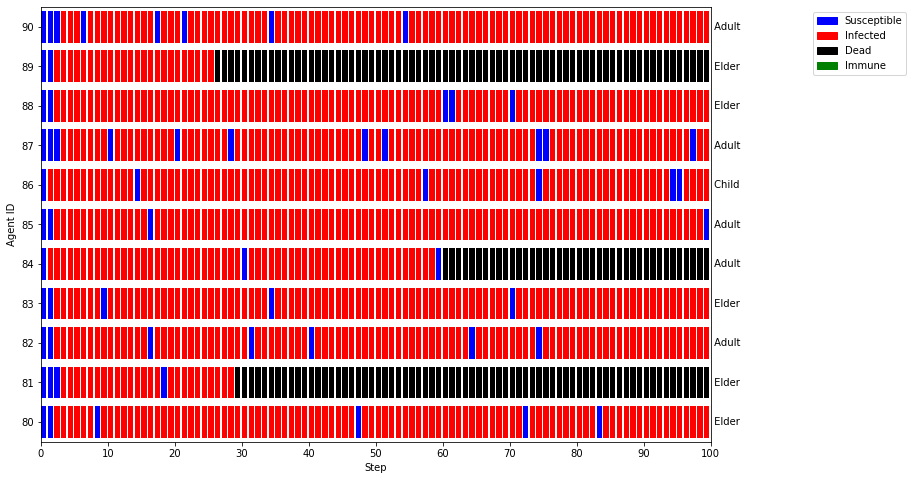

In [109]:
plot_agents_bar(agent_df, [80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90])

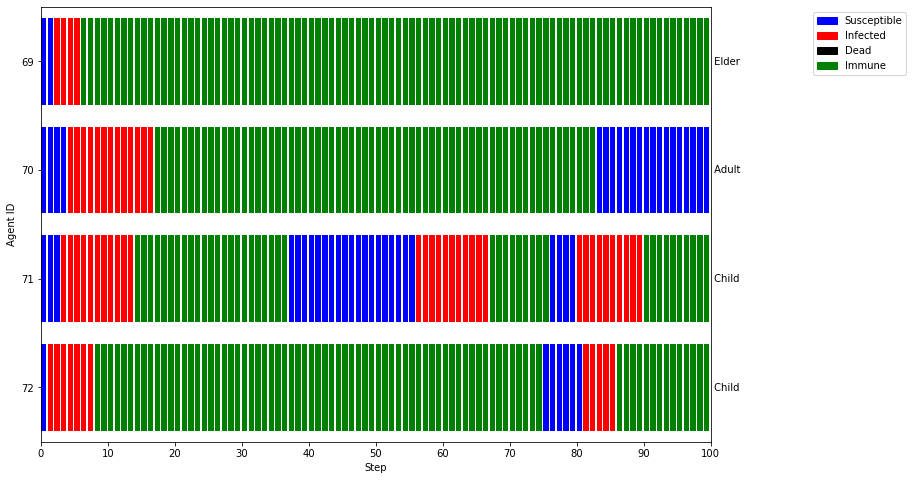

In [107]:
# This is for model 10 i.e prob_trans=0.1, symptomatic_rate=0.15, recovery_type='novax'
agent_df10 = model10.datacollector.get_agent_vars_dataframe()
plot_agents_bar(agent_df10, [72, 71, 70, 69])

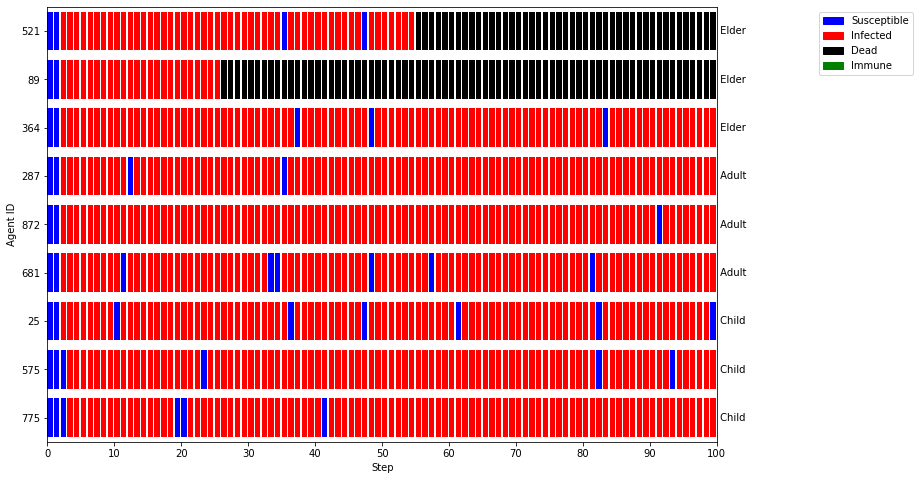

In [98]:
# Pass the selected agent IDs to the plot_agents_bar function
agents = select_agents(agent_df, 3)
plot_agents_bar(agent_df, agents)

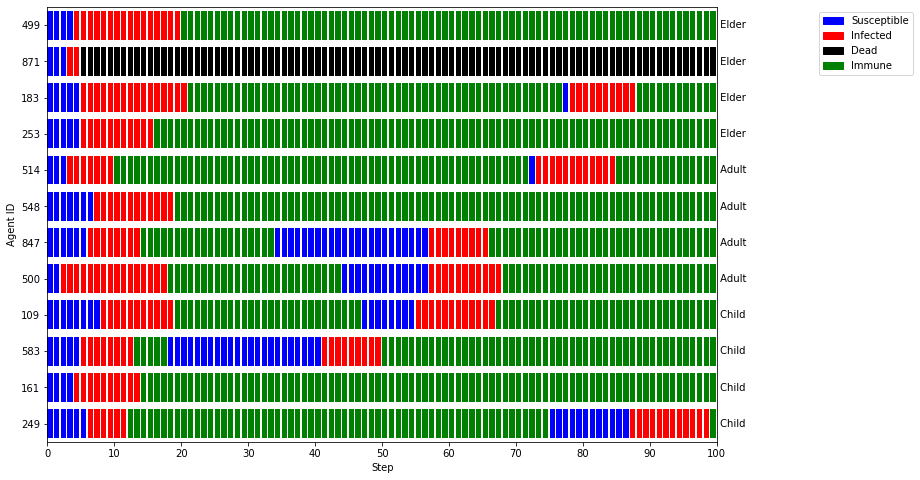

In [106]:
# Model 10 (prob_trans=0.1, symptomatic_rate=0.15, recovery_type='novax')
agent_df10 = model10.datacollector.get_agent_vars_dataframe()
agents = select_agents(agent_df10, 4)
plot_agents_bar(agent_df10, agents)

### For Plotting Aggregates

In [ ]:
# Create the data using our pre-existing table
data = table[['Step', 'Susceptible', 'Infected', 'Immune', 'Dead']]
data = data.melt('Step', var_name='State', value_name='Count')

# Style
sns.set(style='darkgrid')
plt.figure(figsize=(10, 6))

# Line plot
sns.lineplot(data=data, x='Step', y='Count', hue='State')

# Labels
plt.xlabel('Step')
plt.ylabel('Count')
plt.title('Simulation Results with 0.65 Symptomatic Rate, Elusive, 0.3 Prob Trans')

# Show
plt.show()

In [ ]:
# Create an instance of the DiseaseModel
model2 = DiseaseModel(num_agents=1000, num_steps=100, prob_trans=0.3, symptomatic_rate=0.15, recovery_type='elusive')

# Run the simulation and collect data
table2 = model2.run()

# Print or inspect the collected data
print(table2[["Step", "Susceptible", "Infected", "Immune", "Dead"]])

In [ ]:
data2 = table2[['Step', 'Susceptible', 'Infected', 'Immune', 'Dead']]
data2 = data2.melt('Step', var_name='State', value_name='Count')

# Style
sns.set(style='darkgrid')
plt.figure(figsize=(10, 6))

# Line plot
sns.lineplot(data=data2, x='Step', y='Count', hue='State')

# Labels
plt.xlabel('Step')
plt.ylabel('Count')
plt.title('Simulation Results with 0.15 Symptomatic Rate, Elusive, 0.3 Prob Trans')

# Show
plt.show()

In [ ]:
# Create an instance of the DiseaseModel
model3 = DiseaseModel(num_agents=1000, num_steps=100, prob_trans=0.3, symptomatic_rate=0.65, recovery_type='novax')

# Run the simulation and collect data
table3 = model3.run()

# Print or inspect the collected data
print(table3[["Step", "Susceptible", "Infected", "Immune", "Dead"]])

In [ ]:
data3 = table3[['Step', 'Susceptible', 'Infected', 'Immune', 'Dead']]
data3 = data3.melt('Step', var_name='State', value_name='Count')

# Style
sns.set(style='darkgrid')
plt.figure(figsize=(10, 6))

# Line plot
sns.lineplot(data=data3, x='Step', y='Count', hue='State')

# Labels
plt.xlabel('Step')
plt.ylabel('Count')
plt.title('Simulation Results with 0.65 Symptomatic Rate, 0.3 Prob Trans')

# Show
plt.show()

In [ ]:
# Create an instance of the DiseaseModel
model4 = DiseaseModel(num_agents=1000, num_steps=100, prob_trans=0.3, symptomatic_rate=0.15, recovery_type='novax')

# Run the simulation and collect data
table4 = model4.run()

# Print or inspect the collected data
print(table4[["Step", "Susceptible", "Infected", "Immune", "Dead"]])

In [ ]:
data4 = table4[['Step', 'Susceptible', 'Infected', 'Immune', 'Dead']]
data4 = data4.melt('Step', var_name='State', value_name='Count')

# Style
sns.set(style='darkgrid')
plt.figure(figsize=(10, 6))

# Line plot
sns.lineplot(data=data4, x='Step', y='Count', hue='State')

# Labels
plt.xlabel('Step')
plt.ylabel('Count')
plt.title('Simulation Results with 0.15 Symptomatic Rate, 0.3 Prob Trans')

# Show
plt.show()

In [ ]:
# Create an instance of the DiseaseModel
model5 = DiseaseModel(num_agents=1000, num_steps=100, prob_trans=0.3, symptomatic_rate=0.65, recovery_type='vax')

# Run the simulation and collect data
table5 = model5.run()

# Print or inspect the collected data
print(table5[["Step", "Susceptible", "Infected", "Immune", "Dead"]])

In [ ]:
data5 = table5[['Step', 'Susceptible', 'Infected', 'Immune', 'Dead']]
data5 = data5.melt('Step', var_name='State', value_name='Count')


# Style
sns.set(style='darkgrid')
plt.figure(figsize=(10, 6))

# Line plot
sns.lineplot(data=data5, x='Step', y='Count', hue='State')

# Labels
plt.xlabel('Step')
plt.ylabel('Count')
plt.title('Simulation Results with 0.65 Symptomatic Rate, Vaccine Available, 0.3 Prob Trans')

# Show
plt.show()

In [ ]:
# Create an instance of the DiseaseModel
model6 = DiseaseModel(num_agents=1000, num_steps=100, prob_trans=0.3, symptomatic_rate=0.15, recovery_type='vax')

# Run the simulation and collect data
table6 = model6.run()

# Print or inspect the collected data
print(table6[["Step", "Susceptible", "Infected", "Immune", "Dead"]])

In [ ]:
data6 = table6[['Step', 'Susceptible', 'Infected', 'Immune', 'Dead']]
data6 = data6.melt('Step', var_name='State', value_name='Count')

# Style
sns.set(style='darkgrid')
plt.figure(figsize=(10, 6))

# Line plot
sns.lineplot(data=data6, x='Step', y='Count', hue='State')

# Labels
plt.xlabel('Step')
plt.ylabel('Count')
plt.title('Simulation Results with 0.15 Symptomatic Rate, Vaccine Available, 0.3 Prob Trans')

# Show
plt.show()

In [ ]:
# Create an instance of the DiseaseModel
model7 = DiseaseModel(num_agents=1000, num_steps=100, prob_trans=0.1, symptomatic_rate=0.15, recovery_type='elusive')

# Run the simulation and collect data
table7 = model7.run()

# Print or inspect the collected data
print(table7[["Step", "Susceptible", "Infected", "Immune", "Dead"]])

In [ ]:
data7 = table7[['Step', 'Susceptible', 'Infected', 'Immune', 'Dead']]
data7 = data7.melt('Step', var_name='State', value_name='Count')


# Style
sns.set(style='darkgrid')
plt.figure(figsize=(10, 6))

# Line plot
sns.lineplot(data=data7, x='Step', y='Count', hue='State')

# Labels
plt.xlabel('Step')
plt.ylabel('Count')
plt.title('Simulation Results with 0.65 Symptomatic Rate, Elusive, 0.1 Prob Trans')

# Show
plt.show()

In [ ]:
# Create an instance of the DiseaseModel
model8 = DiseaseModel(num_agents=1000, num_steps=100, prob_trans=0.1, symptomatic_rate=0.15, recovery_type='elusive')

# Run the simulation and collect data
table8 = model8.run()

# Print or inspect the collected data
print(table8[["Step", "Susceptible", "Infected", "Immune", "Dead"]])

In [ ]:
data8 = table8[['Step', 'Susceptible', 'Infected', 'Immune', 'Dead']]
data8 = data8.melt('Step', var_name='State', value_name='Count')

# Style
sns.set(style='darkgrid')
plt.figure(figsize=(10, 6))

# Line plot
sns.lineplot(data=data8, x='Step', y='Count', hue='State')

# Labels
plt.xlabel('Step')
plt.ylabel('Count')
plt.title('Simulation Results with 0.15 Symptomatic Rate, Elusive, 0.1 Prob Trans')

# Show
plt.show()

In [ ]:
# Create an instance of the DiseaseModel
model9 = DiseaseModel(num_agents=1000, num_steps=100, prob_trans=0.1, symptomatic_rate=0.65, recovery_type='novax')

# Run the simulation and collect data
table9 = model9.run()

# Print or inspect the collected data
print(table9[["Step", "Susceptible", "Infected", "Immune", "Dead"]])

In [ ]:
data9 = table9[['Step', 'Susceptible', 'Infected', 'Immune', 'Dead']]
data9 = data9.melt('Step', var_name='State', value_name='Count')


# Style
sns.set(style='darkgrid')
plt.figure(figsize=(10, 6))

# Line plot
sns.lineplot(data=data9, x='Step', y='Count', hue='State')

# Labels
plt.xlabel('Step')
plt.ylabel('Count')
plt.title('Simulation Results with 0.65 Symptomatic Rate, 0.1 Prob Trans')

# Show
plt.show()

In [17]:
# Create an instance of the DiseaseModel
model10 = DiseaseModel(num_agents=1000, num_steps=100, prob_trans=0.1, symptomatic_rate=0.15, recovery_type='novax')

# Run the simulation and collect data
table10 = model10.run()

# Print or inspect the collected data
print(table10[["Step", "Susceptible", "Infected", "Immune", "Dead"]])

    Step  Susceptible  Infected  Immune  Dead
0      0          984        16       0     0
0      0          984        16       0     0
1      1          949        51       0     0
0      0          984        16       0     0
1      1          949        51       0     0
..   ...          ...       ...     ...   ...
95    95          140        29     825     6
96    96          149        27     818     6
97    97          153        24     817     6
98    98          156        23     815     6
99    99          167        23     804     6

[5050 rows x 5 columns]


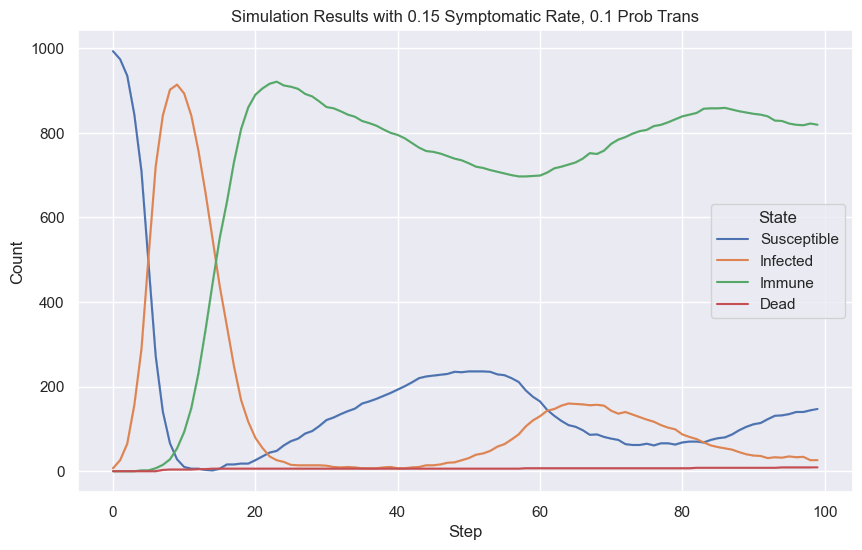

In [21]:
data10 = table10[['Step', 'Susceptible', 'Infected', 'Immune', 'Dead']]
data10 = data10.melt('Step', var_name='State', value_name='Count')

# Style
sns.set(style='darkgrid')
plt.figure(figsize=(10, 6))

# Line plot
sns.lineplot(data=data10, x='Step', y='Count', hue='State')

# Labels
plt.xlabel('Step')
plt.ylabel('Count')
plt.title('Simulation Results with 0.15 Symptomatic Rate, 0.1 Prob Trans')

# Show
plt.show()

In [ ]:
# Create an instance of the DiseaseModel
model11 = DiseaseModel(num_agents=1000, num_steps=100, prob_trans=0.1, symptomatic_rate=0.65, recovery_type='vax')

# Run the simulation and collect data
table11 = model11.run()

# Print or inspect the collected data
print(table11[["Step", "Susceptible", "Infected", "Immune", "Dead"]])

In [ ]:
data11 = table11[['Step', 'Susceptible', 'Infected', 'Immune', 'Dead']]
data11 = data11.melt('Step', var_name='State', value_name='Count')


# Style
sns.set(style='darkgrid')
plt.figure(figsize=(10, 6))

# Line plot
sns.lineplot(data=data11, x='Step', y='Count', hue='State')

# Labels
plt.xlabel('Step')
plt.ylabel('Count')
plt.title('Simulation Results with 0.65 Symptomatic Rate, Vaccine, 0.1 Prob Trans')

# Show
plt.show()

In [ ]:
# Create an instance of the DiseaseModel
model12 = DiseaseModel(num_agents=1000, num_steps=100, prob_trans=0.1, symptomatic_rate=0.15, recovery_type='vax')

# Run the simulation and collect data
table12 = model12.run()

# Print or inspect the collected data
print(table12[["Step", "Susceptible", "Infected", "Immune", "Dead"]])

In [ ]:
data12 = table12[['Step', 'Susceptible', 'Infected', 'Immune', 'Dead']]
data12 = data12.melt('Step', var_name='State', value_name='Count')

# Style
sns.set(style='darkgrid')
plt.figure(figsize=(10, 6))

# Line plot
sns.lineplot(data=data12, x='Step', y='Count', hue='State')

# Labels
plt.xlabel('Step')
plt.ylabel('Count')
plt.title('Simulation Results with 0.15 Symptomatic Rate, Vaccine, 0.1 Prob Trans')

# Show
plt.show()